In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Stan

In [3]:
import utilities.stan_utility as stan_utility
import pystan
import matplotlib as mpl

import scipy.stats as stats
from scipy.stats import kde


In [6]:
light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200


In [ ]:
with open('stan/gamma.stan', 'r') as file:
    print(file.read())

In [39]:
gamma_model = stan_utility.compile_model('stan/gamma.stan')

Using cached StanModel


In [6]:
sim = gamma_model.sampling(data={'alpha': 10, 'beta': 2},
                          algorithm="Fixed_param",
                          iter=1000,
                          warmup=0,
                          chains=1,
                          seed=25052020)

In [7]:
params=sim.extract()
gamma=params['gamma']
inv_gamma=params['inv_gamma']

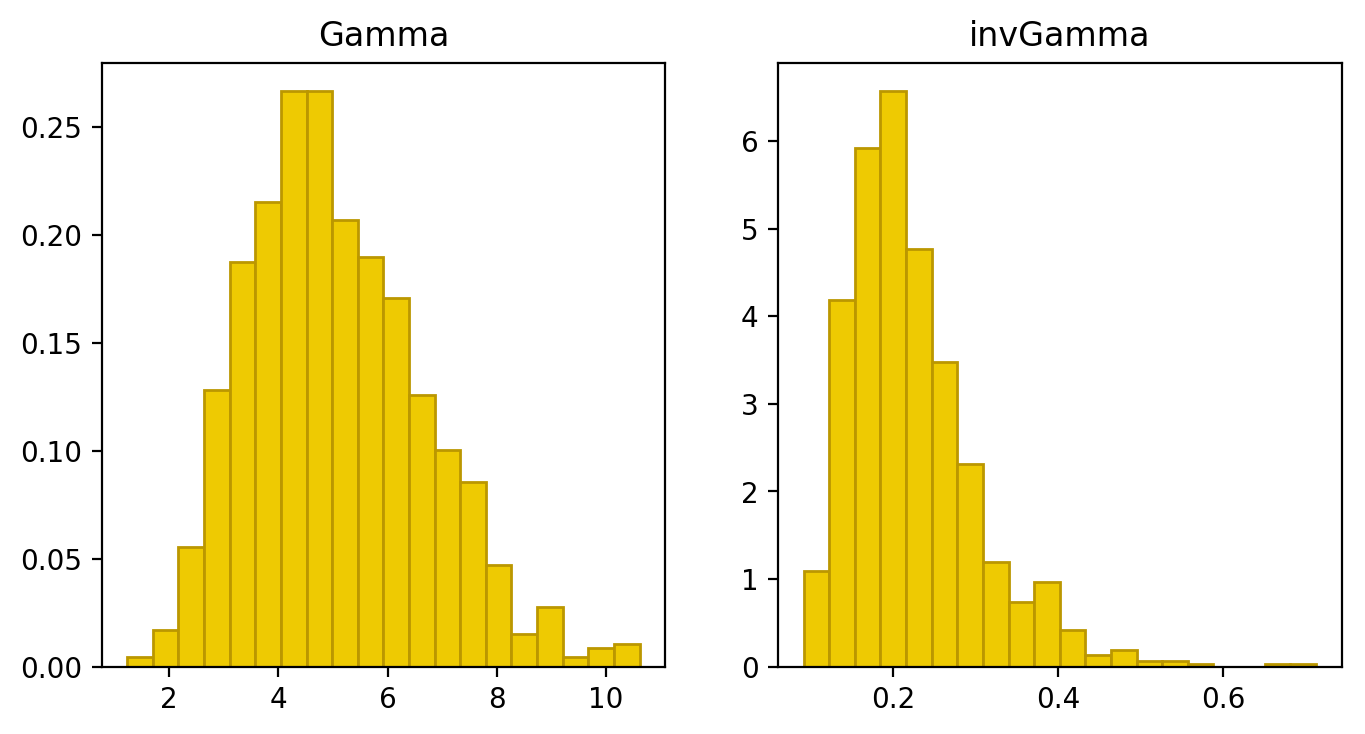

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1=axes[0]
ax1.hist(gamma,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,10,500)

ax2=axes[1]
ax2.hist(inv_gamma,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x2=np.linspace(0,10,500)

ax1.set_title('Gamma')
ax2.set_title('invGamma')
plt.show()

In [10]:
with open('stan/gamma_tune.stan', 'r') as file:
    print(file.read())

functions {
    vector rightGamma (vector y, vector theta, real[] x_r, int[] x_i) {
        vector[2] gammas;
        gammas[1] = gamma_cdf(theta[1], exp(y[1]), exp(y[2])) - 0.01;
        gammas[2] = 0.99 - gamma_cdf(theta[2], exp(y[1]), exp(y[2]));
        return gammas;
    }
}

data {
    real lowerBound;
    real upperBound;
    real alphaGuess;
    real betaGuess;
}

transformed data {
    vector[2] y;
    real x_r[0];
    int x_i[0];
    vector[2] theta = [lowerBound, upperBound]';
	
    vector[2] y_guess = [log(alphaGuess), log(betaGuess)]';
    y = algebra_solver(rightGamma, y_guess, theta, x_r, x_i);
}

generated quantities {
    real alpha = exp(y[1]);
    real beta = exp(y[2]);
}



In [11]:
gamma_tuning=stan_utility.compile_model('stan/gamma_tune.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0496034a91c68b89b1864262b08003da NOW.


In [31]:
data = dict(lowerBound =5 , upperBound=10, alphaGuess=10, betaGuess=2) #  
tuned = gamma_tuning.sampling(data=data,
                                seed=28052020,
                                algorithm="Fixed_param",
                                iter=1000, 
                                warmup=0,
                                chains=1)

In [49]:
alpha = np.round(tuned.extract()['alpha'][0])
beta = np.round(tuned.extract()['beta'][0])
print(f'alpha: {alpha}\tbeta: {beta}')

alpha: 46.0	beta: 6.0


In [50]:
sim_gamma = gamma_model.sampling(data={'alpha': alpha, 'beta': beta},
                          algorithm="Fixed_param",
                          iter=1000,
                          warmup=0,
                          chains=1,
                          seed=25052020)

In [51]:
params=sim_gamma.extract()
par_gamma=params['gamma']

In [15]:
with open('stan/invgamma_tune.stan', 'r') as file:
    print(file.read())

functions {
    vector rightGamma (vector y, vector theta, real[] x_r, int[] x_i) {
        vector[2] gammas;
        gammas[1] = inv_gamma_cdf(theta[1], exp(y[1]), exp(y[2])) - 0.01;
        gammas[2] = 0.99 - inv_gamma_cdf(theta[2], exp(y[1]), exp(y[2]));
        return gammas;
    }
}

data {
    real lowerBound;
    real upperBound;
    real alphaGuess;
    real betaGuess;
}

transformed data {
    vector[2] y;
    real x_r[0];
    int x_i[0];
    vector[2] theta = [lowerBound, upperBound]';
	
    vector[2] y_guess = [log(alphaGuess), log(betaGuess)]';
    y = algebra_solver(rightGamma, y_guess, theta, x_r, x_i);
}

generated quantities {
    real alpha = exp(y[1]);
    real beta = exp(y[2]);
}



In [54]:
inv_gamma_tuning=stan_utility.compile_model('stan/invgamma_tune.stan')

Using cached StanModel


In [55]:
data = dict(lowerBound =5 , upperBound=10, alphaGuess=2, betaGuess=5)
inv_tuned = inv_gamma_tuning.sampling(data=data,
                                seed=28052020,
                                algorithm="Fixed_param",
                                iter=1000, 
                                warmup=0,
                                chains=1)

In [57]:
alpha = np.round(inv_tuned.extract()['alpha'][0])
beta = np.round(inv_tuned.extract()['beta'][0])
print(f'alpha: {alpha}\tbeta: {beta}')


alpha: 46.0	beta: 314.0


In [58]:
sim_gamma_inv = gamma_model.sampling(data={'alpha': alpha, 'beta': beta},
                          algorithm="Fixed_param",
                          iter=1000,
                          warmup=0,
                          chains=1,
                          seed=25052020)

In [60]:
inv_params=sim_gamma_inv.extract()
par_inv_gamma=inv_params['inv_gamma']

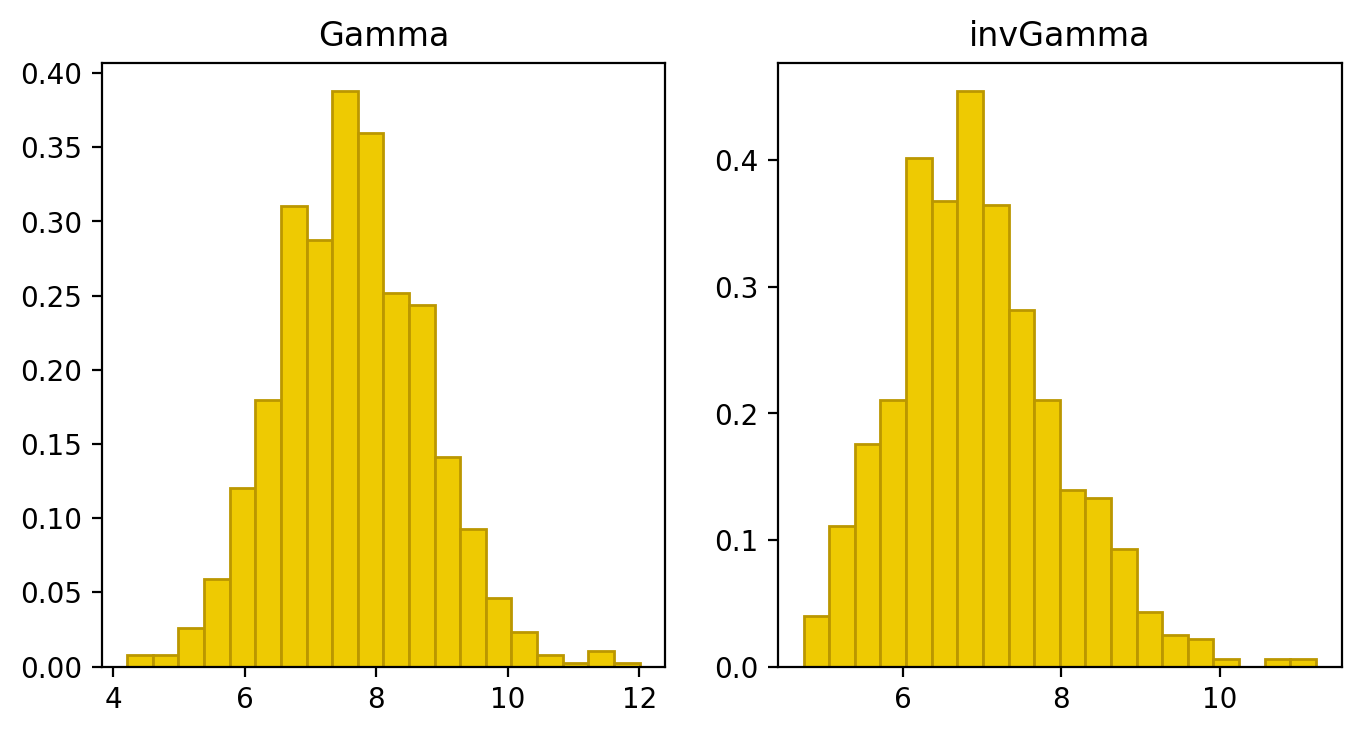

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1=axes[0]
ax1.hist(par_gamma,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,10,500)

ax2=axes[1]
ax2.hist(par_inv_gamma,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x2=np.linspace(0,10,500)

ax1.set_title('Gamma')
ax2.set_title('invGamma')
plt.show()

In [42]:
with open('stan/negative.stan', 'r') as file:
    print(file.read())

negative_model = stan_utility.compile_model('stan/negative.stan')

data {
    real alpha;
    real mean_;
    real phi;
}

generated quantities {
    real neg_con = neg_binomial_rng(alpha, alpha/mean_);
    real neg_dis = neg_binomial_2_rng(mean_, phi);

    real poisson_con = poisson_rng(mean_);
}



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f4c27b0e4c37367e5cf8398a65dcd455 NOW.


In [43]:
data = dict(mean_=10, alpha=2, phi=2) 
negative_sampled = negative_model.sampling(data=data,
                                            seed=25052020,
                                            algorithm="Fixed_param",
                                            iter=1000, 
                                            warmup=0,
                                            chains=1)

In [44]:
params=negative_sampled.extract()
neg_bin_con=params['neg_con']
poisson_con=params['poisson_con']
neg_bin_dis=params['neg_dis']

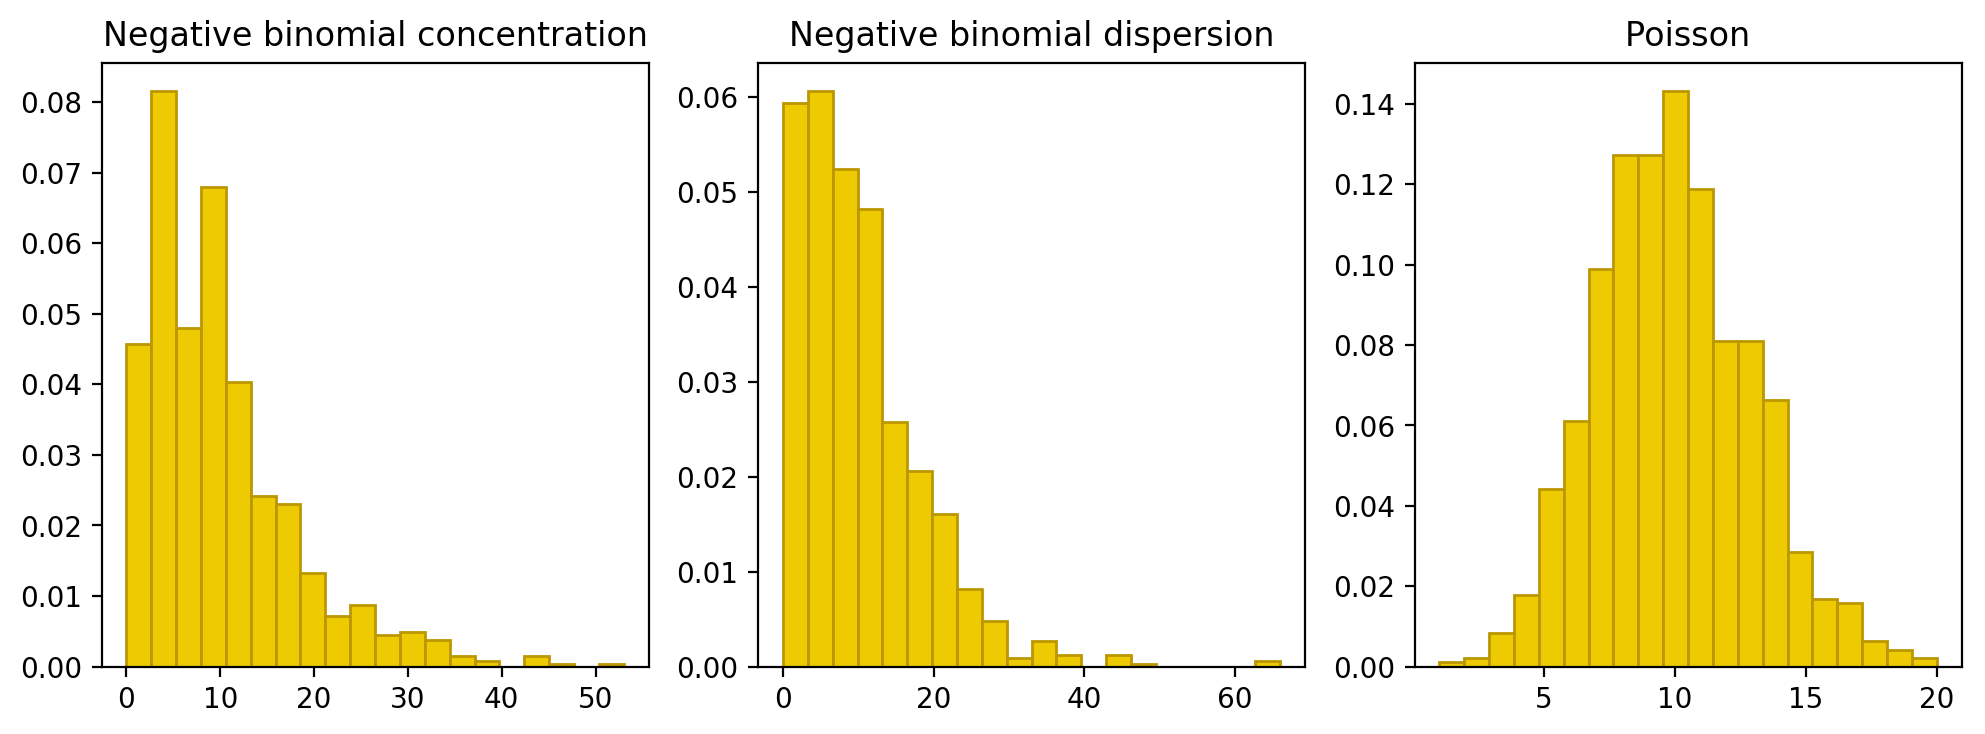

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

ax1=axes[0]
ax1.hist(neg_bin_con,bins=20, color=dark, edgecolor=dark_highlight, density=True)
ax1.set_title(r'Negative binomial concentration')

ax3=axes[1]
ax3.hist(neg_bin_dis,bins=20, color=dark, edgecolor=dark_highlight, density=True)
ax3.set_title(r'Negative binomial dispersion')

ax2=axes[2]
ax2.hist(poisson_con,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title('Poisson')

plt.show()

In [50]:
with open('stan/student_t.stan', 'r') as file:
    print(file.read())
student_t = stan_utility.compile_model('stan/student_t.stan')

data {
    real nu;    //degrees of freedom
    real mu;    //location
    real sigma; //scale
}

generated quantities {
    real y_sim = student_t_rng(nu, mu, sigma);
}


Using cached StanModel


In [82]:
sim_1=student_t.sampling(data={'nu':5, 'mu':0, 'sigma':2},
                      algorithm="Fixed_param", 
                      iter=100, 
                      warmup=0, 
                      chains=1,
                      seed=25052020)
sim_2=student_t.sampling(data={'nu':5, 'mu':1, 'sigma':2},
                      algorithm="Fixed_param", 
                      iter=1000, 
                      warmup=0, 
                      chains=1,
                      seed=25052020)
sim_cauchy=student_t.sampling(data={'nu':1, 'mu':0, 'sigma':2},
                      algorithm="Fixed_param", 
                      iter=100, 
                      warmup=0, 
                      chains=1,
                      seed=25052020)

In [83]:
params1=sim_1.extract()
student1=params1['y_sim']

params2=sim_2.extract()
student2=params2['y_sim']

params3=sim_cauchy.extract()
student3=params3['y_sim']

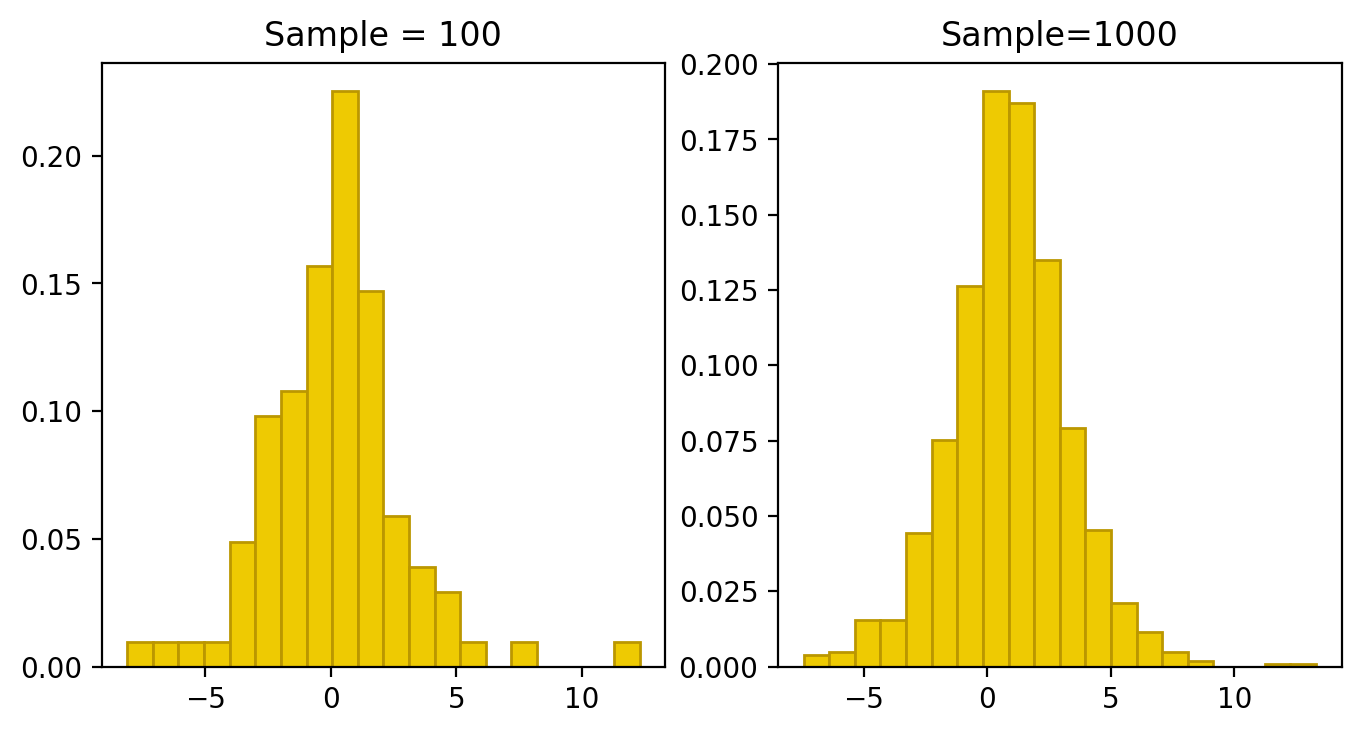

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax1=axes[0]
ax1.hist(student1,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title(r'Sample = 100')

ax2=axes[1]
ax2.hist(student2,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title(r'Sample=1000')

plt.show()

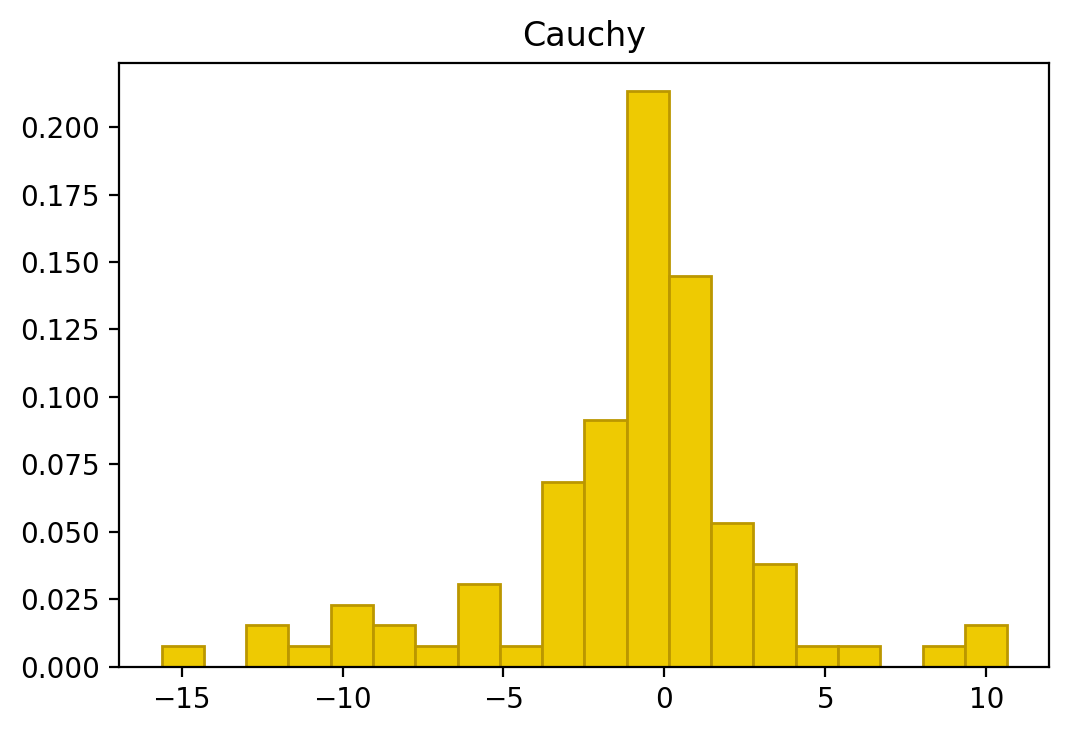

In [75]:
plt.title('Cauchy',x= 0.5,y=1, fontsize=12)
plt.hist(student1,bins=20,color=dark,edgecolor=dark_highlight,density=True)

plt.show()

In [79]:
print(np.median(student1),
np.median(student2),
np.var(student1),
np.var(student2))



-0.5803838598352855 0.9876861845469028 16.867715824764232 29.071910900783738


In [93]:
with open('stan/normal.stan') as file:
    print(file.read())
normal = stan_utility.compile_model('stan/normal.stan')

data {
    vector[2] mu;       // location
    matrix[2,2] sigma;  // scale
	real eta;       // location
}


generated quantities {
    vector[2] result = multi_normal_rng(mu,sigma);
	
	matrix[2, 2] correl_matrix = lkj_corr_cholesky_rng(2, eta);

 }
Using cached StanModel


In [94]:
data = dict(mu=[2, 1], sigma=[[1, 0.5],[0.5, 2]], eta=2)
normal = normal.sampling(data=data,
                                seed=2852020,
                                algorithm="Fixed_param",
                                iter=1000, 
                                warmup=0,
                                chains=1)


In [105]:
params = normal.extract()
y_sim = params['result'].T
corrMatrix = params['correl_matrix']

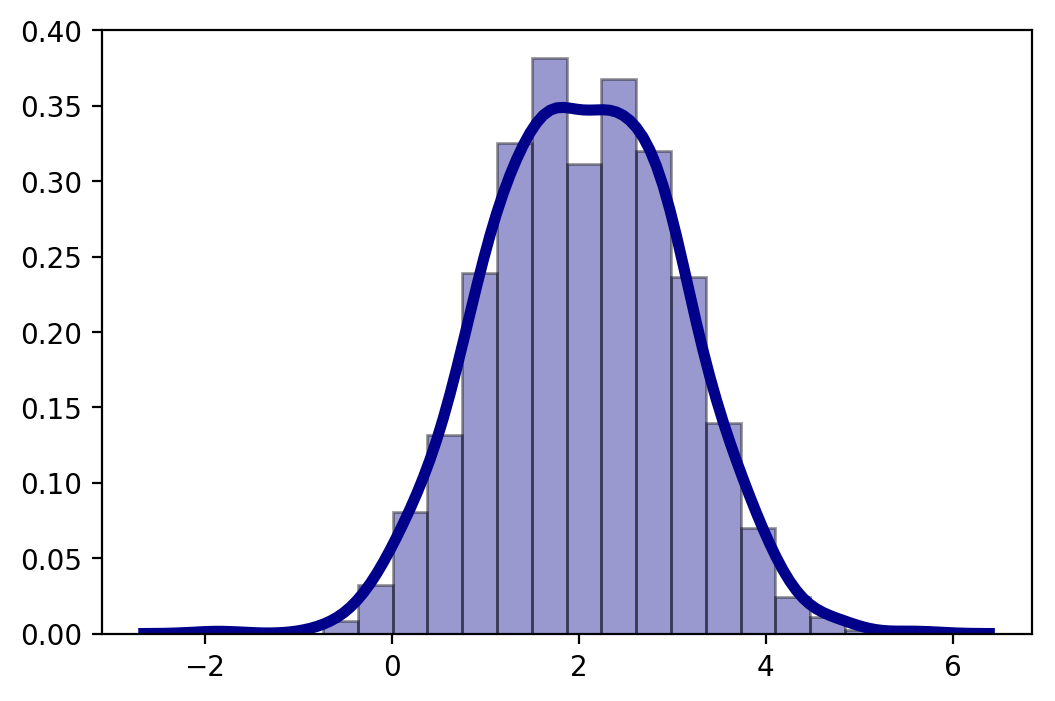

In [90]:
# Density Plot and Histogram of all arrival delays
sns.distplot(y_sim[0].flatten(), hist=True, kde=True, 
             bins=20, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [91]:
to_df = np.array([y_sim[0].flatten(), y_sim[1].flatten()]).T
df = pd.DataFrame(to_df, columns=["normal1", "normal2"])

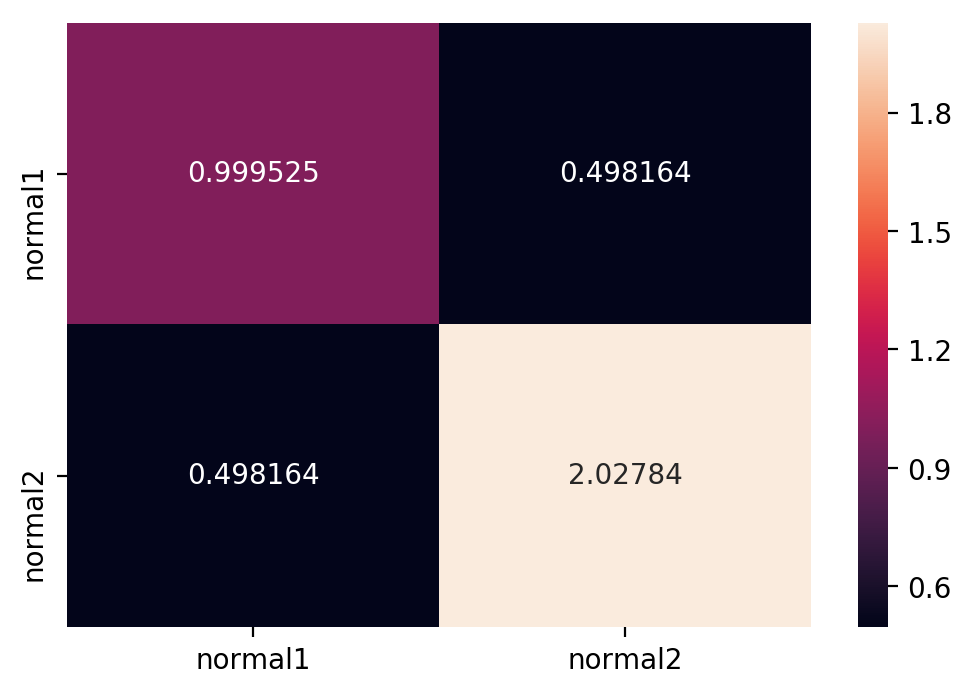

In [101]:
covMatrix = pd.DataFrame.cov(df)
sns.heatmap(covMatrix, annot=True, fmt='g')
plt.show()

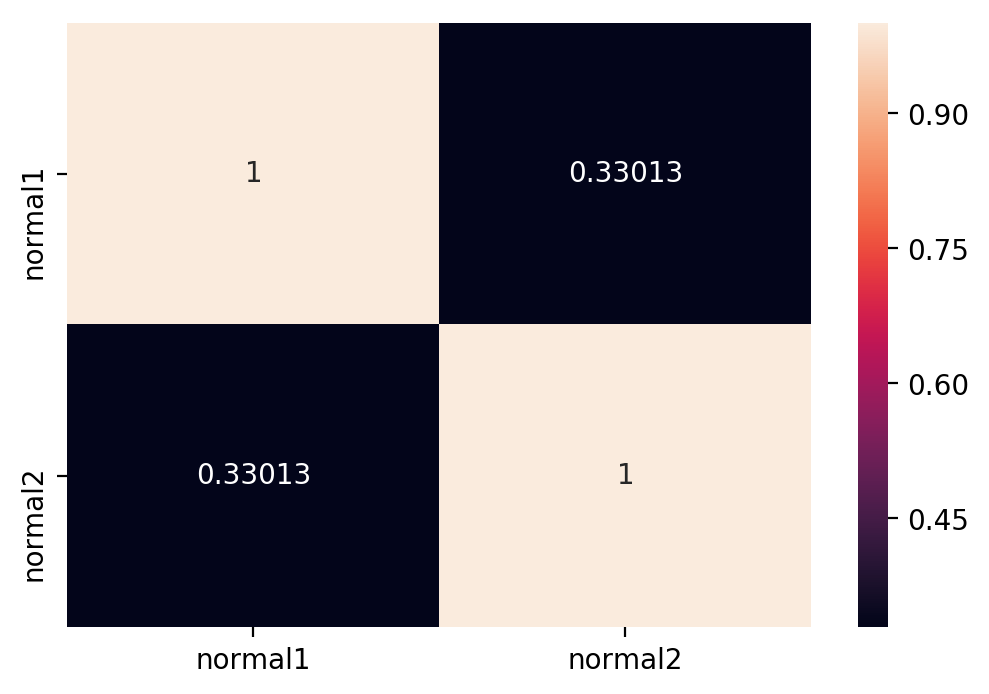

In [119]:
corrMatrix = pd.DataFrame.corr(df)
sns.heatmap(corrMatrix, annot=True, fmt='g')
plt.show()

In [120]:
with open('stan/normal3.stan', 'r') as file:
    print(file.read())
normal_3 = stan_utility.compile_model('stan/normal3.stan')

data {
    vector[3] mu;       // location
    matrix[3,3] sigma;  // scale
}


generated quantities {
    vector[3] result = multi_normal_rng(mu,sigma);
}



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_663f286b80b2c56f24e2355209441ebb NOW.


In [128]:
mu = [2, 8, 12]
sigma = [[1, 0.3, 0.2], [0.3, 2, 0.3],[0.2, 0.3, 2]]

In [129]:
R1=100
sim_3=normal_3.sampling(data={'mu':mu, 'sigma':sigma},
                      algorithm="Fixed_param", 
                      iter=R1, 
                      warmup=0, 
                      chains=1,
                      seed=28052020)

In [131]:
params1 = sim_3.extract()
result = params1['result']
result = result.T

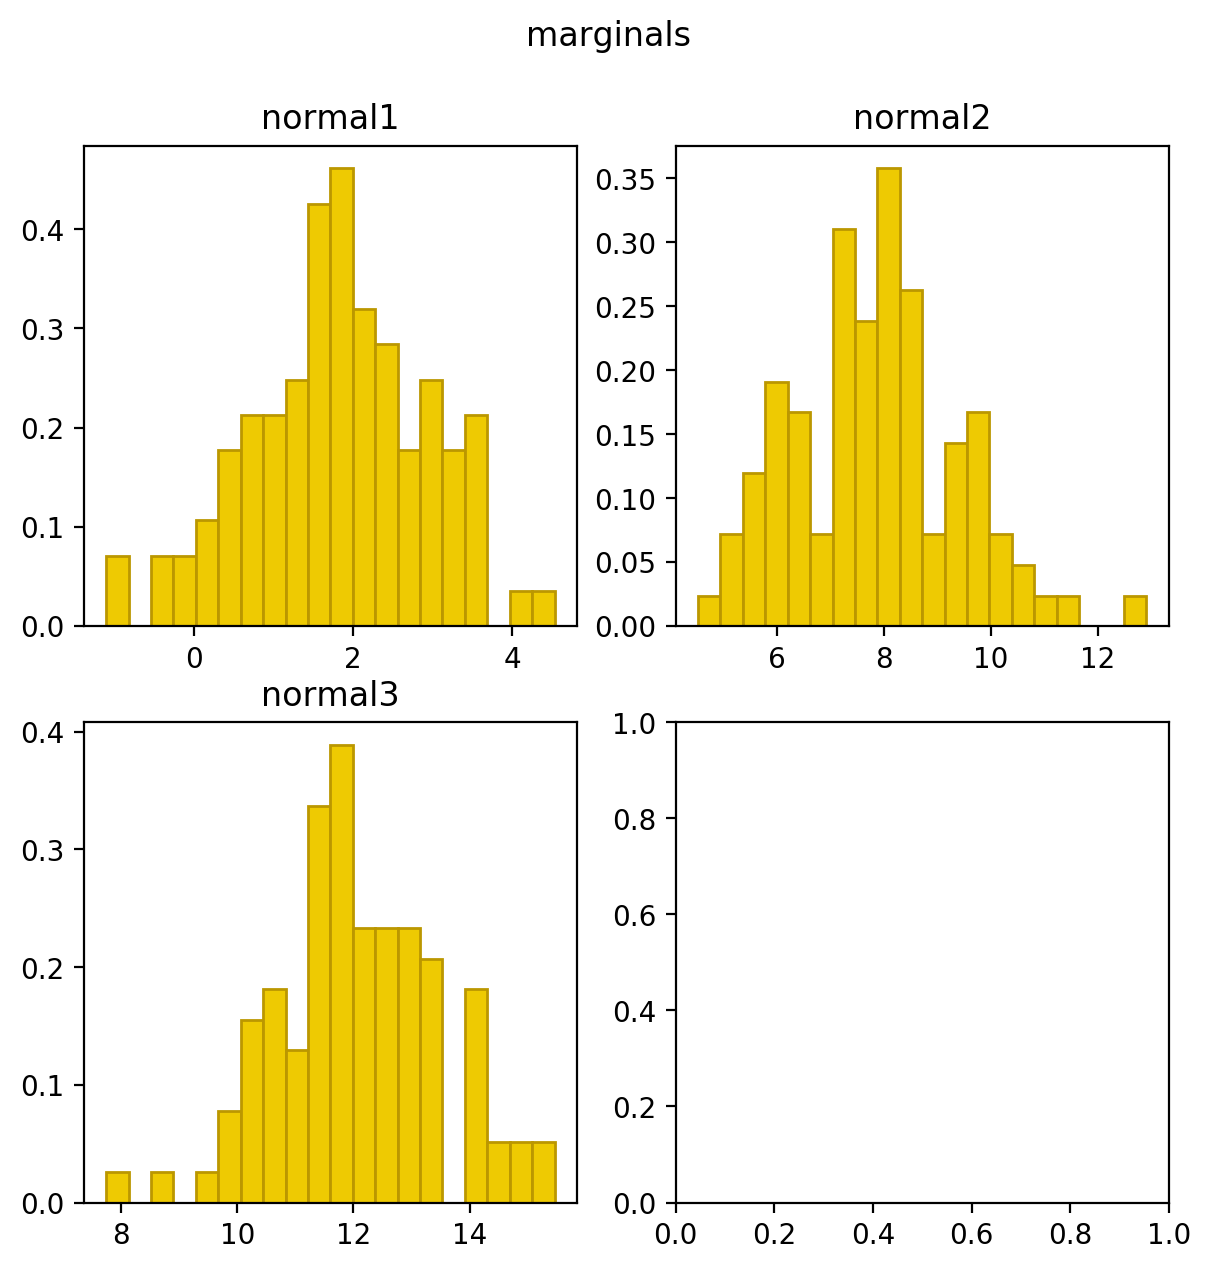

In [133]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

fig.suptitle('marginals',x= 0.5,y=0.97, fontsize=12)

ax1=axes[0][0]
ax1.hist(result[0],bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title(r'normal1')

ax2=axes[0][1]
ax2.hist(result[1],bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title(r'normal2')

ax2=axes[1][0]
ax2.hist(result[2],bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title(r'normal3')


plt.show()


In [134]:
with open('stan/normal4.stan', 'r') as file:
    print(file.read())
normal_4 = stan_utility.compile_model('stan/normal4.stan')

data {
    vector[4] mu;       // location
    matrix[4,4] sigma;  // scale
}


generated quantities {
    vector[4] result = multi_normal_rng(mu,sigma);
}

Using cached StanModel


In [135]:
mu = [2, 8, 2, 8]
sigma = [[1, 0.3, 0.2,0.1], [0.3, 2, 0.3,0.1],[0.2, 0.3, 2,0.1],[0.1,0.1,0.1,1]]

In [136]:
R1=100
sim_4=normal_4.sampling(data={'mu':mu, 'sigma':sigma},
                      algorithm="Fixed_param", 
                      iter=R1, 
                      warmup=0, 
                      chains=1,
                      seed=28052020)

In [137]:
params1 = sim_4.extract()
result = params1['result']
result = result.T

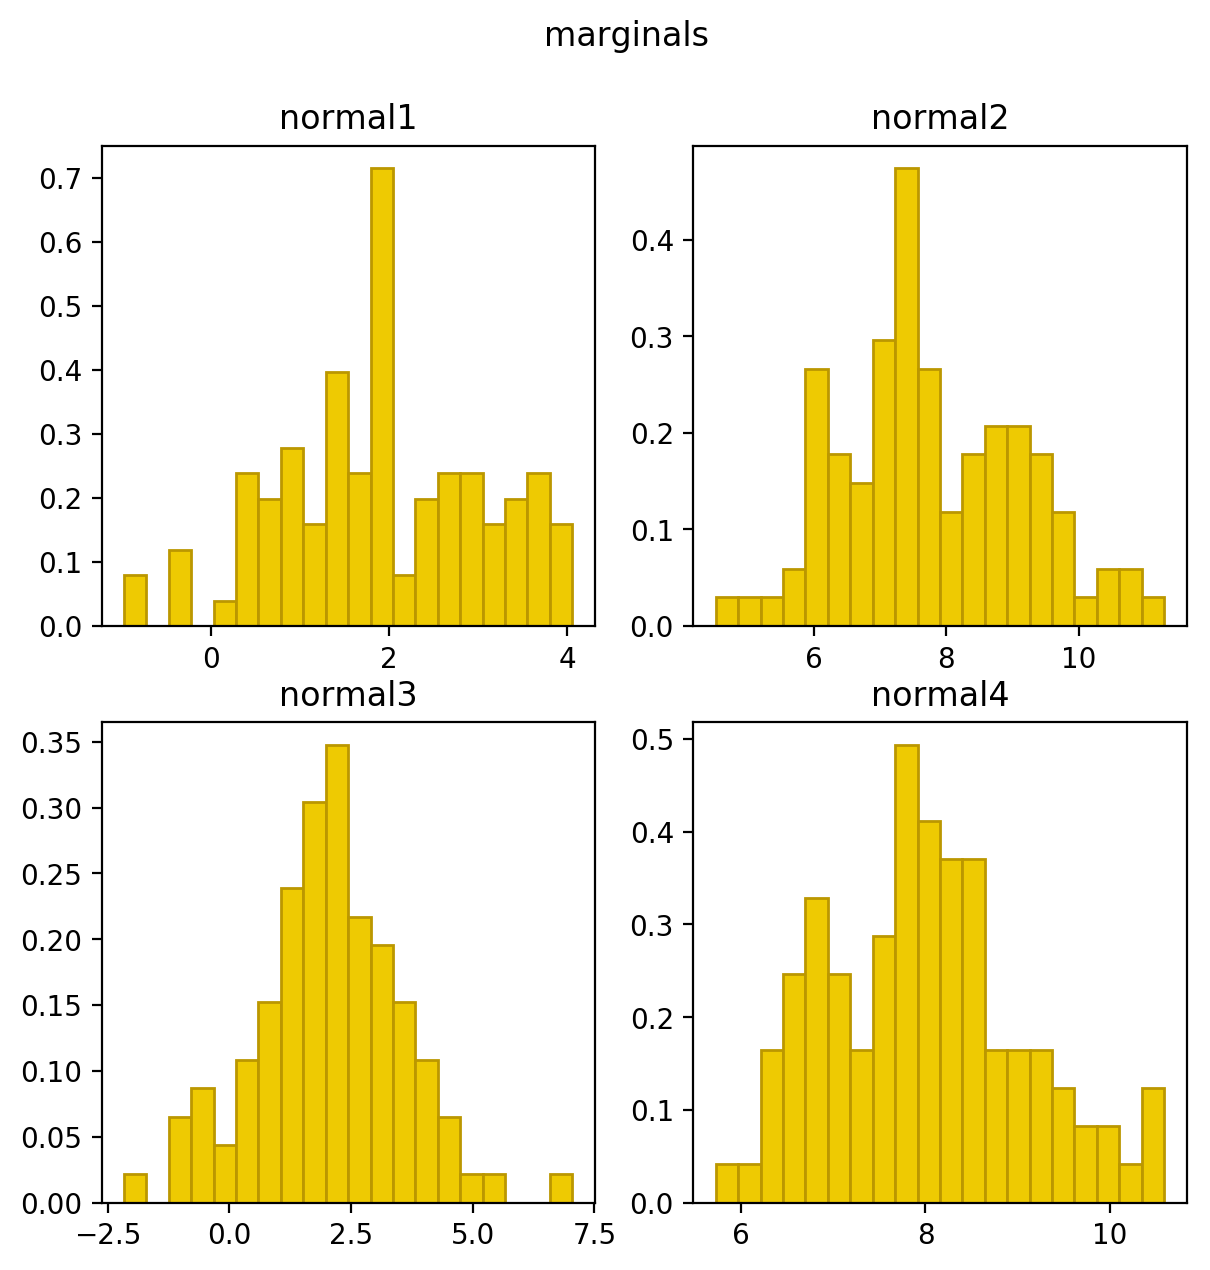

In [138]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

fig.suptitle('marginals',x= 0.5,y=0.97, fontsize=12)

ax1=axes[0][0]
ax1.hist(result[0],bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title(r'normal1')

ax2=axes[0][1]
ax2.hist(result[1],bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title(r'normal2')

ax2=axes[1][0]
ax2.hist(result[2],bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title(r'normal3')

ax2=axes[1][1]
ax2.hist(result[3],bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title(r'normal4')

plt.show()
